# Checkpoint 3: Convolutional neural networks and autoencoders
---
*Responsible:* Guillermo Hamity (<ghamity@ed.ac.uk>)



In this checkpoint exercise we will use the Quick Draw dataset. 

The Quick Draw Dataset is a collection of 50 million drawings across 345 categories, contributed by players of the game Quick, Draw!. The bitmap dataset contains these drawings converted from vector format into 28x28 grayscale images.

We will focus on a subset of 10 classes of type "body part"

The class labels are:

![listbodypart](./list_body_parts.png)

| <p align='left'> Label                   | <p align='left'> Description| 
| ---------------------------------------- | --------------------------- |
| <p align='left'> 0                       | <p align='left'> arm        |
| <p align='left'> 1                       | <p align='left'> ear        | 
| <p align='left'> 2                       | <p align='left'> eye        |  
| <p align='left'> 3                       | <p align='left'> face      | 
| <p align='left'> 4                       | <p align='left'> foot       | 
| <p align='left'> 5                       | <p align='left'> hand       | 
| <p align='left'> 6                       | <p align='left'> knee       |
| <p align='left'> 7                       | <p align='left'> leg        |
| <p align='left'> 8                       | <p align='left'> mouth      |
| <p align='left'> 9                       | <p align='left'> nose     |


Players draw items as quickly as possible, and as you can see, some images are quite bad! We will try and train a CNN classifier to anyway see if we can train a model to distinguish the classes. We will then train an autoencoder to learn a laten space representations of the dataset.

    
This week, like last, I am not providing example notebooks like `lecture2.ipynb` and `data-science-tools.ipynb` for Unit 2, though these may still be useful to you. Instead, I am **providing the imports for all of the modules and classes that you should need.** 

### Notes on assessment
* Try and calculate the answers to the exercises provided. If you are unable to complete the question, describe which approach you _would_ have taken to solve the problem
* Code must be understandable and reproducible. Before grading the notebook kernel **may** be restarted and re-run, so make sure that your code can run from start to finish without any (unintentional) errors
* If you are unsure on how to proceed please **ask one of the TAs** during the workshop
- Notebooks should be submitted by **10am on Friday 22 October 2021** 
- This CP exercise sheet is divided into **5 sections** giving a maximum of **10 marks** in total:

| <p align='left'> Title          | <p align='left'> Exercise nos. | <p align='center'> Number of marks |
| ---------------------------------------- | --------------------- | -------------------- |
| <p align='left'> 1. Visualisation and Abstraction   | <p align='left'>   1  | <p align='left'> 1.5 |
| <p align='left'> 2. Image classification | <p align='left'> 2–5  | <p align='left'> 3.5 | 
| <p align='left'> 3. Auto-encoders        | <p align='left'> 6–9  | <p align='left'> 3.0 |
| <p align='left'> 4. Anomaly detection    | <p align='left'> 10–11| <p align='left'> 2.0 |
| <p align='left'> **Total**               |                       | <p align='left'> **10** |

---
You can find the dataset for download at [this link](https://cernbox.cern.ch/index.php/s/obvLeyMR0JEEa5p).
---
---

## Preamble
---

In [4]:
# Standard import(s)
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd


In [5]:
# Keras import(s)
if float(tf.__version__[:3])>2.8:
    from tensorflow.keras.utils import plot_model
else:
    from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense, Flatten, Reshape, Conv2D, MaxPooling2D, AveragePooling2D, UpSampling2D
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from tensorflow.keras import regularizers

from tensorflow.python.keras.backend import set_image_data_format
set_image_data_format('channels_last')  # Images are formatted as (N, N, 1), with colour-channels last

## Data preprocessing (given, not marked)
---

First, we'll load in the preprocessed dataset from a numpy data file, which has already been split into training and testing parts for us.



* Each image has been **Reshaped to** $(N,N,1)$ dimension, i.e. image has one color dimention
* Images have been **Scaled** to have pixel intensities in the range [0,1]. It is an important step before feeding them to the neural network model, by dividing the values by 255. It's important that the training set and the testing set be preprocessed in the same way.
* Dataset was **Shuffled** for both training and testing datasets separately.
* Check the shapes of the resulting arrays; make sure they look as you expect.

In [6]:
#Load quickdraw bodyparts dataset
X_train, y_train, X_test, y_test = np.load('quickdraw_bodyparts.npy',allow_pickle=True) 


In [110]:
# check shapes for better understanding of the data
print(X_train.shape)  
print(y_train.shape)

(160000, 28, 28, 1)
(160000,)


In [7]:
#Image labels
body_parts = ['arm', 'ear', 'eye', 'face','foot', 'hand', 'knee', 'leg', 'mouth','nose']

In [112]:
# Each label of the dataset correspond to a class name
class_names = body_parts

nb_train   = X_train.shape[0]
nb_test    = X_test.shape[0]
nb_classes = y_train.max() + 1
print("Number of training examples: {}".format(nb_train))
print("Number of testing  examples: {}".format(nb_test))
print("Number of target classes:    {}".format(nb_classes))

# Get image shape
shape = X_train.shape[1:]
print("Image shape:  {}".format(shape))

Number of training examples: 160000
Number of testing  examples: 40000
Number of target classes:    10.0
Image shape:  (28, 28, 1)


## Image visualisation and abstraction (1.5 marks)

#### 1. Display images of the training dataset, and check that the associated label makes sense (0.5 mark)

You will use `matplotlib.pyplot`, the `plt.imshow` method. Use the `cmap=plt.cm.binary` color map for all subsequent img plots.

1. plot 10 training dataset images, one per category. Label the images.

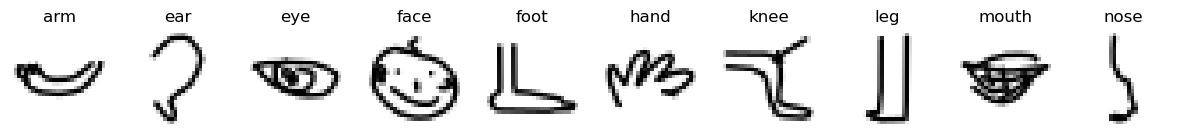

In [113]:
# plot images with titles
fig = plt.figure(figsize=(15, 15))
columns = 10
rows = 1

#range starts with 1 because we do not want 0 columns/rows
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    # to get one of each category iterate over y_train indices from 0 to 9 
    plt.imshow(X_train[y_train==i-1][0], cmap = plt.cm.binary)
    plt.title(body_parts[i-1])
    plt.axis("off")
plt.show()

2. plot the fist 25 images in a 5x5 plot. Label the images.

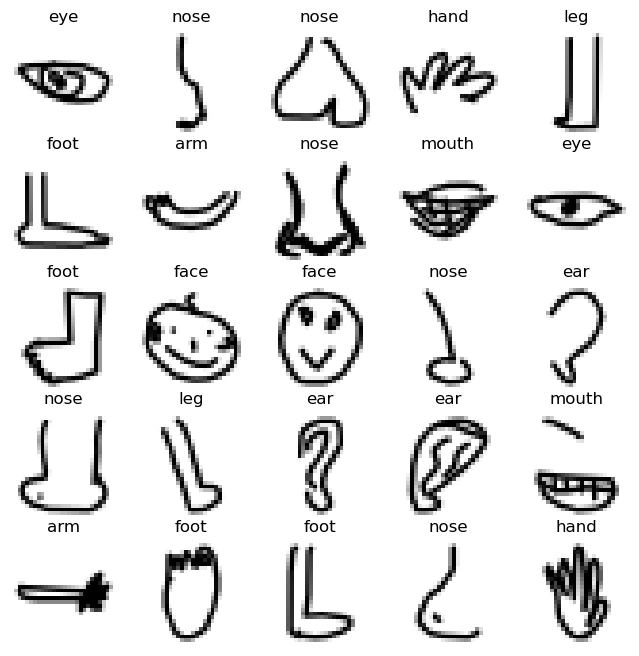

In [114]:
# plot first 25 images with titles
fig = plt.figure(figsize=(8, 8))
columns = 5
rows = 5
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    # to get first 25 iterate over X_train 
    plt.imshow(X_train[i-1], cmap = plt.cm.binary)
    # indice to match with label
    ind = int(y_train[i-1])
    plt.title(body_parts[ind])
    plt.axis("off")
plt.show()

#### 2 Apply different kernels to an image of type face (1 mark)

1. pick an image of the face type and save it to `myface`. Plot it with `imshow` (nothing fancy needed for the plot)

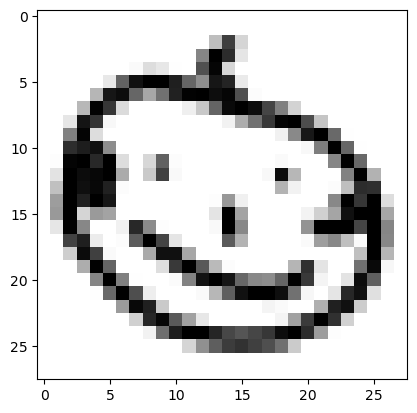

In [115]:
# plotting a face (indice for label 3)
myface = X_train[y_train==3][0].reshape(28,28)
plt.imshow(myface,cmap = plt.cm.binary);

2. Define 4 kernels: identity, edge_detection, sharpening, and blurring, as `3x3` numpy arrays. We add them to a dictionary of kernels.

In [116]:
# definning kernels
k_identity = np.zeros((3,3)) 
k_identity[1,1] = 1 
k_edge= -1*np.ones((3,3)) 
k_edge[1,1] = 8
k_sharp= np.array([[0,-1,0],[-1,5,-1],[0,-1,0]] )
k_blur = np.ones((3,3))/9

#kernels dictionary
kernels = {"identity":k_identity,"edge":k_edge,"sharp":k_sharp,"blur":k_blur}

3. Given is part of the `run_kernel` function which runs over the figure and applies the kernel to every non-edge pixel. Complete the function:
    - Define the shape of the output image `np.empty(...)`
    - Define the ranges of the row and colum loops , i.e. `range(...)`
    - Define the fig index on which the kernel is multiplied in each step, ie. `fig[....]`



In [117]:
def run_kernel(fig,kernel):
    #empty array holding the output image. Define the output dimensions as excercise.
    out = np.empty((myface.shape[0] - 2,myface.shape[1] - 2 ,1))
    for i in range(myface.shape[0] - 2 ):
        for j in range(myface.shape[1] -2 ):
            out[i][j] = np.sum(np.multiply(kernel,fig[i:i+3 , j:j+3]))
                    
    return out
    

4. run the plotting code block below and check that the kernels are doing what you expect.
    
Since some kernels multiply by negatives, we use the norm=norm(0,1) to scale the image back to between 0 and 1 before plotting. 

In [118]:
#Import the normiliser for the bitmap
from matplotlib.colors import Normalize as norm

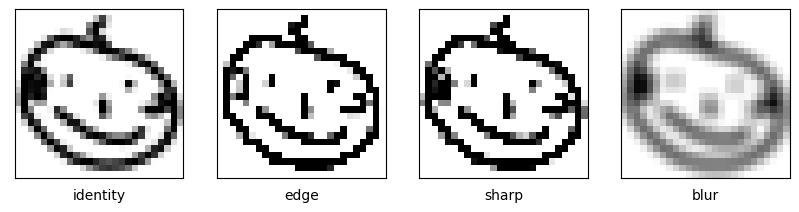

In [119]:
plt.figure(figsize=(10,10))
#Loop over kernel
for i,kernel in enumerate(kernels):
    plt.subplot(1,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    #return transformed image and plot it
    plt.imshow(run_kernel(myface,kernels[kernel]), cmap=plt.cm.binary,norm=norm(0,1))  
    plt.xlabel(kernel)
plt.show()




## Image classification (3.5 mark)
---
In this section, we will train a convolutional neural network (CNN) to perform hand-written digit recognition; a standard form of image classification. We will:
- create the model
- train the model
- evaluate its classification performance

#### 3. Define a Convolutional Neural Network suitable for image classification (1 mark).

* Use the **`Keras` functional API** to construct the model. 
* The shape of the input layer should match the shape of the prepared images.
* Add some **convolutional** and **pooling** layers in a sensible configuration. The architecture is a bit up to you, but try to reach a good level of accuracy. Around 85% on validation seems easily achievable.
    * By default, you can use $3 \times 3$ kernels, ReLU activation, and $2\times 2$ pooling; but feel free to play around with different values.
    * By default no padding is applied. You could try "same" padding in order to use the whole image, though results don't change much for me.
    * If sufferening from large overtraining could try regularisation: `kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)`
   
* **Flatten** the output of the last convolutional layer.
* Connect it, to an **output** layer with the appropriate number of nodes and choice of activation function.
* Display the model architecture using the `<model>.summary()` method. Optionally display it also with the `plot_model(<model>, show_shapes=True)` method.  
* Questions:
    * _What are the number of trainable parameters in the model?_
    * _How many trainable parameters does your first convolutional layer have? Why?_
    * _Which layer has the most trainable parameters?_

In [18]:
# Define network 
visible = Input(shape=(28,28,1))
conv1 = Conv2D(16, kernel_size = (3,3), activation = "relu" , padding = "same")(visible)
pool1 = MaxPooling2D(pool_size = (2,2))(conv1)
conv2 = Conv2D(8, kernel_size = (3,3), activation = "relu", padding = "same")(pool1)
pool2 = MaxPooling2D(pool_size = (2,2))(conv2)
flat = Flatten()(pool2)
hidden  = Dense(15, activation = "relu" )(flat)
output = Dense(len(body_parts), activation = "softmax" )(hidden)
model = Model(visible, output)

model.summary()


2022-10-27 21:34:25.254658: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 392)               0         
_________________________________________________________________
dense (Dense)                (None, 15)                5895  

### Answers to questions
The number of trainable parameters is: 7375
The first convulation layer has 160 parameters. This is because for a convolutional layer the number of parameters is going to be: [Kernel size (3x3) + bias (1)] * Number of modes (16) -> [(3x3)+1]*16 = 160. 
The layer with the most trainable parameters is the first Dense layer (hidden). It takes all the flatten parameters from the output (7x7x8) = 392, and hence the number of trainable parameters is [(7x7x8) * 15 (number of nodes)] + 1x15 (bias) = 5895

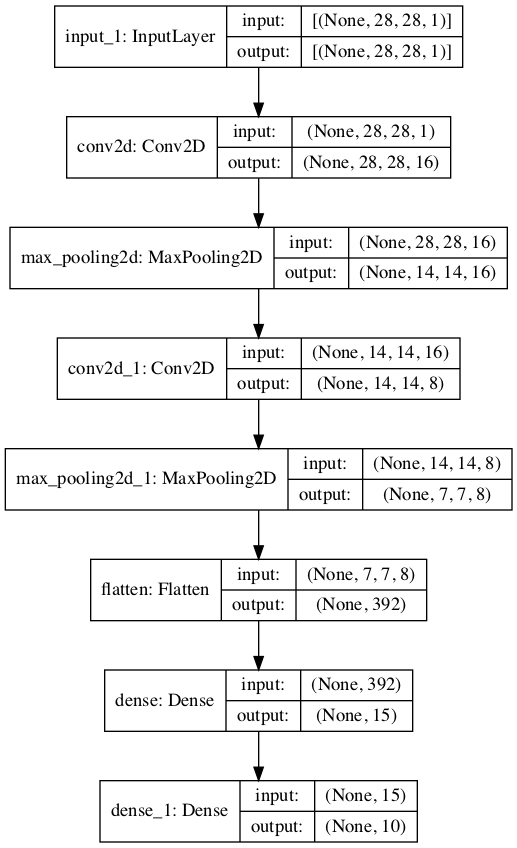

In [19]:
plot_model(model, show_shapes = "True")

#### 4. Compile and train the CNN image classifier (1 mark)

* Choose the appropriate loss functiton. 
* Fit for a reasonable number of epochs, use 20% of data for validation. 
* Plot the loss curve(s) by using `matplotlib.pyplot` directly with the information in the `<model>.history.history` dict.
* If you run on CPUs, stretch your legs while you wait for the 20 epoches to complete. Now is a good time for a coffee/loo break!

In [21]:
# compiling and trainning CNN
model.compile("adam", loss="sparse_categorical_crossentropy", metrics = "accuracy" )
history_a = model.fit(X_train, y_train, epochs=1, batch_size=32, validation_split = 0.2)

Epoch 1/20
4000/4000 [==============================] - 68s 17ms/step - loss: 0.5847 - accuracy: 0.8124 - val_loss: 0.5846 - val_accuracy: 0.8131
Epoch 2/20
4000/4000 [==============================] - 64s 16ms/step - loss: 0.5522 - accuracy: 0.8239 - val_loss: 0.5553 - val_accuracy: 0.8185
Epoch 3/20
4000/4000 [==============================] - 60s 15ms/step - loss: 0.5233 - accuracy: 0.8317 - val_loss: 0.5414 - val_accuracy: 0.8252
Epoch 4/20
4000/4000 [==============================] - 65s 16ms/step - loss: 0.5115 - accuracy: 0.8353 - val_loss: 0.5352 - val_accuracy: 0.8283
Epoch 5/20
4000/4000 [==============================] - 58s 15ms/step - loss: 0.5041 - accuracy: 0.8379 - val_loss: 0.5205 - val_accuracy: 0.8322
Epoch 6/20
4000/4000 [==============================] - 56s 14ms/step - loss: 0.4913 - accuracy: 0.8401 - val_loss: 0.5272 - val_accuracy: 0.8313
Epoch 7/20
4000/4000 [==============================] - 59s 15ms/step - loss: 0.4874 - accuracy: 0.8411 - val_loss: 0.5143 -

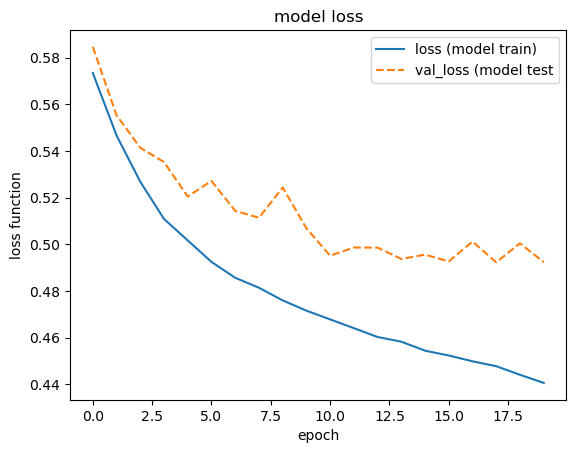

In [24]:
plt.plot(history_a.history['loss'])
plt.plot(history_a.history['val_loss'],linestyle='dashed')
plt.title('model loss')
plt.ylabel('loss function')
plt.xlabel('epoch')
plt.legend(['loss (model train)', 'val_loss (model test)'], loc='upper right')
plt.show()

#### 5. Evaluate the classification performance on the testing dataset (1 Mark)

* Compute the testing accuracy, _e.g._ using the `<model>.evaluate()` method. Compare to the training accuracy; can be read off from fit printout, if you added the `'accuracy'` metric, or can be calculated here.
* Display a few mis-classified images from the test dataset.
    * For this you will need to use the model to predict from the testing features.
    * This yields arrays of 10 probabilities, 1 per class. Get the index from maximum probability to find the class prediction. Maybe consider using `argmax`?
* Compute and display the confusion matrix (normalise by truth label). Discuss the results.

In [120]:
print("Accuracy trainning: ", history_a.model.evaluate(X_train, y_train)[1])
print("Accuracy test: ", history_a.model.evaluate(X_test, y_test)[1]) 

5000/5000 [==============================] - 26s 5ms/step - loss: 0.4462 - accuracy: 0.8523
Accuracy trainning:  0.8522812724113464
1250/1250 [==============================] - 9s 7ms/step - loss: 0.4912 - accuracy: 0.8407
Accuracy test:  0.8406500220298767


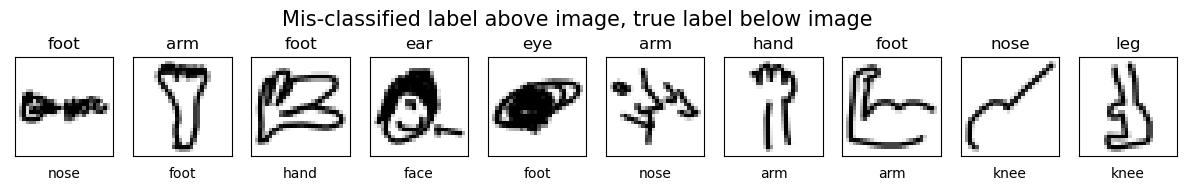

In [148]:
# mis-classified images

from matplotlib.pyplot import legend


y_pred = history_a.model.predict(X_test)
y_class = np.argmax(y_pred, axis = 1)

# mis-classifed cases 
indic = np.argwhere(y_test != y_class).flatten()
indic = np.array(indic, dtype = int)

# plot figures with titles
fig = plt.figure(figsize=(15, 2))
columns = 10
rows = 1

#range starts with 1 because we do not want 0 columns/rows
for i in range(1, columns*rows +1):
    fig.suptitle('Mis-classified label above image, true label below image', fontsize=15)
    fig.add_subplot(rows, columns, i)
    
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.imshow(X_test[indic][i].reshape(28,28,1), cmap = plt.cm.binary, norm=norm(0,1))

    plt.title(body_parts[int(y_class[indic][i])])
    plt.xlabel(body_parts[int(y_test[indic][i])])

plt.show()


In [32]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

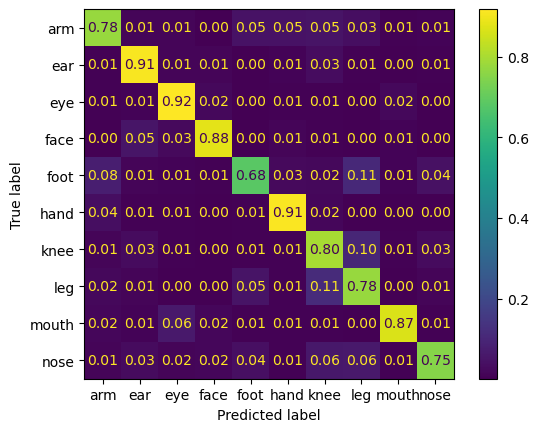

In [33]:
# display the confussion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_class, normalize='true', display_labels = body_parts, values_format = ".2f")

The overall accuracy by random guess for this case would be of around 10% (as there are 10 possibilities).
The matrix shows that all the true labesl falls in the diagonal, so the classification was succesful.
The percentages of the diagonal are high (all higher than 60%, and most of them higher than 80%).
It seems that identifying a foot is the most difficult one.


For your own interest (not marked) run the first layer kernels over `myface`. You should see several copies of the image, all with varying transformations. In your training you may find different kernels, but I can clearly spot a bluring kernel in my first layer.

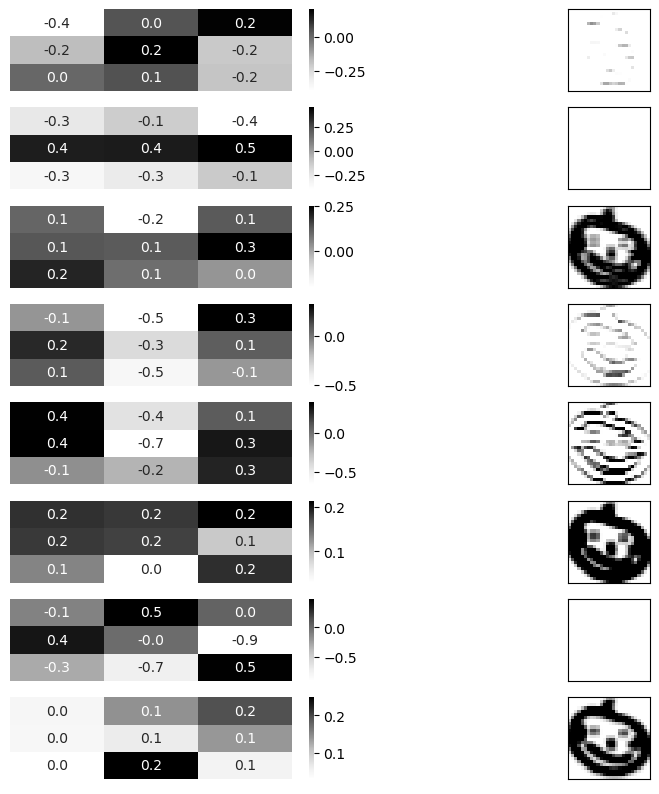

In [106]:
plt.figure(figsize=(10,10))
for i in range(8):
    plt.subplot(8,2,2*(i)+1)

    sns.heatmap(model.layers[1].get_weights()[0][:,:,:,i][:,:,0], cmap='Greys',annot=True,fmt=".1f")
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.subplot(8,2,2*i+2)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(run_kernel(myface,model.layers[1].get_weights()[0][:,:,:,i]),cmap=plt.cm.binary,norm=norm(0,1))
plt.show()


## Auto-encoders (3 marks)
---
In this section, we will construct and train an auto-encoder as an example of **unsupervised learning.** This type of model is made up of an **encoder** that maps an image of shape $(N,M,C)$ into a latent vector of shape $(L,)$; and a **decoder** which maps the latent vector into an image with the same shape as the original. The latent, or encoded, vector will typically be small in size compared to the input image (_i.e._ $L \ll N \times M \times C$), meaning that it is an **information bottleneck.** The aim of the auto-encoder is therefore to learn the most efficient encoding of a class of images (here: quickdraw dataset) that allows the decoder to reconstruct the original as well as possible under the bottleneck constraint.

We will break down this task into a few sub-tasks, to make it easier to get through.

#### 6. Construct the encoder (1 Marks)

* Use the `Keras` functional API to construct the encoder model. 
* The shape of the input layer should match the shape of the prepared images .
* Add some convolutional and pooling layers in a sensible configuration. 
    * Using a decreasing number of kernels for each convolutional layer (_e.g._ $16 \to 8 \to 4 \to 2 \to 1$) works quite well.
    * For this task it is worthwhile to give some thought to padding: You want to have intermediate layers with shapes that are easy to reconstruct with the decoder. As a starting point, consider using `padding='same'` for your conv. layers.
    * **See also the note below.**
* **Flatten** the output of the last convolutional layer, and use this as the latent vector. 
    * For convenience, we choose to make the latent vector have values in the range [0,1], so add the appropriate activation function to the preceeding convolutional layer.
* Display the model architecture using the `<model>.summary()` method, optionally also the `plot_model(<model>, show_shapes=True)` method.
    * These methods are also very useful for debugging, when you are building your network. For instance, start with the simplest possible `Keras` model; plot the architecture using one of these methods; modify the model slightly; plot the architecture again to see the effect; _etc._
    * Make sure that the output of the encoder is indeed a bottleneck, _i.e._ that the number of output nodes is significantly smaller than the number of pixels in the image. (_Hint: A latent vector could have size $49 \ll 28 \times 28 \times 1 = 784$._)
    
**Note:** Choosing the architecture for an auto-encoder can be a bit tricky. The input images we use have shape $(28,28,1)$, and when we're pooling we typically downsample by a factor of $2$. If we use "same" padding, this means that we can go down to $(7,7,F)$ with no issues. However, if we downsample further (_e.g._ $7\to 3$) it will be tricky for the decoder to reconstruct, since upsampling would result in $3\to 6$. Therefore, to keep things simple, it may be best to not downsample further than $(7,7,F)$. However, you can still add _multiple convolutional layers in a row without pooling._

In [8]:
# constructing then encoder
input_imag = Input(shape=(28,28,1))
enc_conv1 = Conv2D(16, kernel_size = (3,3), activation = "relu" , padding = "same")(input_imag)
enc_pool1 = MaxPooling2D(pool_size = (2,2))(enc_conv1)
enc_conv2 = Conv2D(8, kernel_size = (3,3), activation = "relu", padding = "same")(enc_pool1)
enc_pool2 = MaxPooling2D(pool_size = (2,2))(enc_conv2)
enc_conv3 = Conv2D(4, kernel_size = (3,3), activation = "relu", padding = "same")(enc_pool2)
enc_conv4 = Conv2D(2, kernel_size = (3,3), activation = "relu", padding = "same")(enc_conv3)
enc_conv5 = Conv2D(1, kernel_size = (3,3), activation = "relu", padding = "same")(enc_conv4)
enc_flat = Flatten()(enc_conv5)
model_enc = Model(input_imag, enc_flat)

model_enc.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 4)           292       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 2)           74    

2022-11-03 13:49:32.838392: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


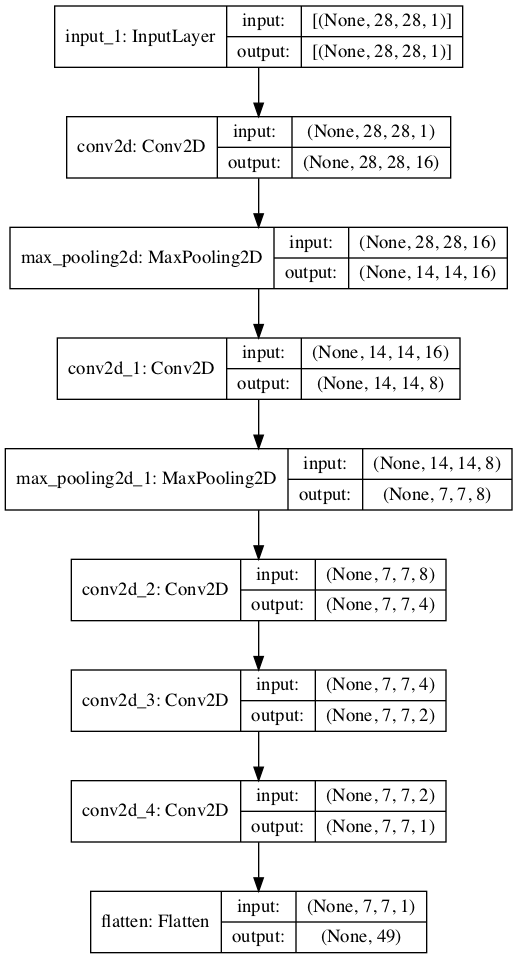

In [9]:
plot_model(model_enc, show_shapes = "True")

#### 7. Construct the decoder (1 Mark)

* Use the `Keras` functional API to construct the decoder model. 
* **Reshape** the latent vector to have the shape of the last convolutional layer in the encoder.
* The shape of the input layer should match the shape of the latent vector.
* Add some convolutional and **upsampling** layers in a sensible configuration. 
    * You can use the same order of kernels (_e.g._ $16 \to 8 \to 4 \to 2 \to 1$) as in the encoder.
    * Many of the notes and considerations mentioned for the encoder hold for the decoder as well.
* The output of the decoder should have the same shape as the number images. Also, choose an output activation that is appropriate to the dataset.
* Display the model architecture using the `<model>.summary()` method, optionally also the `plot_model(<model>, show_shapes=True)` method.
    * As for the encoder, these methods can be very useful for debugging.

In [18]:
# construct the decoder
input_dec = Input(shape=(49))
reshape_dec = Reshape((7,7,1))(input_dec)
dec_conv1 = Conv2D(16, kernel_size = (3,3), activation = "relu" , padding = "same")(reshape_dec)
dec_pool1 = UpSampling2D((2,2))(dec_conv1)
dec_conv2 = Conv2D(8, kernel_size = (3,3), activation = "relu", padding = "same")(dec_pool1)
dec_pool2 = UpSampling2D( (2,2))(dec_conv2)
dec_conv3 = Conv2D(4, kernel_size = (3,3), activation = "relu", padding = "same")(dec_pool2)
dec_conv4 = Conv2D(2, kernel_size = (3,3), activation = "relu", padding = "same")(dec_conv3)
dec_conv5 = Conv2D(1, kernel_size = (3,3), activation = "sigmoid", padding = "same")(dec_conv4)
model_dec = Model(input_dec, dec_conv5)

model_dec.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 49)]              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 1)           0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 16)          160       
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 28, 28, 8)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 4)         292 

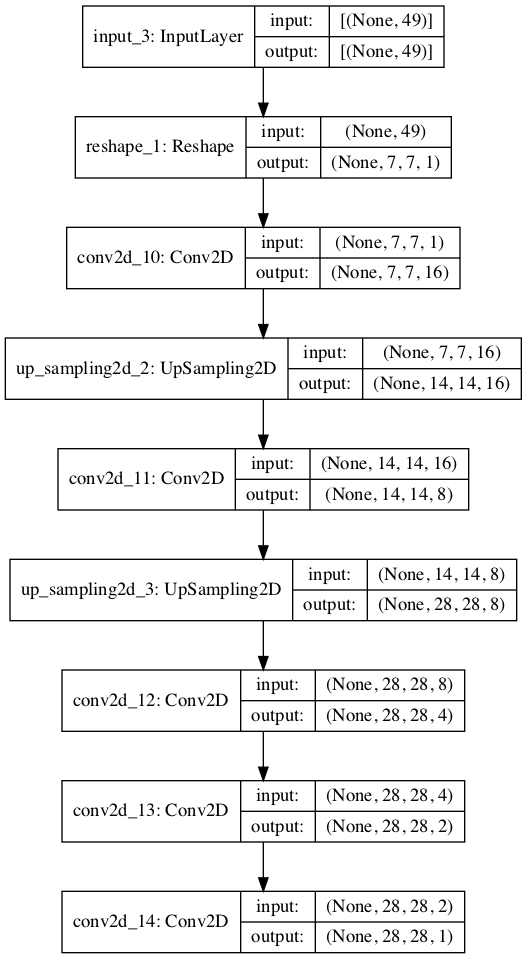

In [19]:
plot_model(model_dec, show_shapes = "True")

#### 8. Construct the auto-encoder (given, not marked)

Connecting the encoder and decoder to form the auto-encoder is a slightly tricky use of the `Keras` functional API, so I'll just give that to you. Assuming you have given you encoder and decoder intuitive names, the following should do the trick:

In [20]:
i   = model_enc.input
cae = Model(i, model_dec(model_enc(i)), name='ConvAE')
cae.summary()

Model: "ConvAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
model (Functional)           (None, 49)                1705      
_________________________________________________________________
model_2 (Functional)         (None, 28, 28, 1)         1705      
Total params: 3,410
Trainable params: 3,410
Non-trainable params: 0
_________________________________________________________________


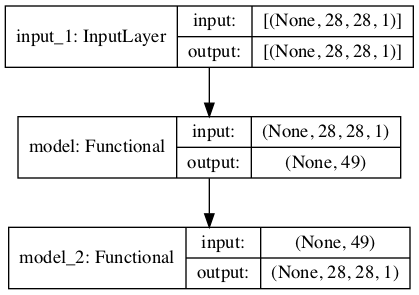

In [21]:
plot_model(cae, show_shapes = "True")

Try to make sure that you understand what is going on here: In the `Keras` functional API, layers and even entire models work like functions (thus the name). What we're doing above is passing an input image `i` through the encoder (resulting in a latent vector); passing the output of `encoder` as the input to `decoder` (resulting in a reconstructed image); and finally using the output of `decoder` as the output of the auto-encoder.

#### 9. Compile and train the auto-encoder (1 Mark)

* Choose an appropriate loss function.
* Train for ca. 10 epochs with some data held out for validation. Time for another coffee break!
* Plot the loss curve(s).
* Perform the auto-encoding for the testing images (use the `<model>.predict()` method) and display the first couple of _(a)_ original and _(b)_ auto-encoded images to see whether the outputs resembles the original images.

In [23]:
cae.compile("adam", loss="mse", metrics = "accuracy")
history_cae = cae.fit(X_train, X_train, epochs=10, batch_size=32, validation_split = 0.2) 
 

Epoch 1/10
4000/4000 [==============================] - 310s 77ms/step - loss: 0.0204 - accuracy: 0.7812 - val_loss: 0.0194 - val_accuracy: 0.7820
Epoch 2/10
4000/4000 [==============================] - 258s 65ms/step - loss: 0.0194 - accuracy: 0.7819 - val_loss: 0.0191 - val_accuracy: 0.7818
Epoch 3/10
4000/4000 [==============================] - 241s 60ms/step - loss: 0.0188 - accuracy: 0.7823 - val_loss: 0.0186 - val_accuracy: 0.7822
Epoch 4/10
4000/4000 [==============================] - 254s 63ms/step - loss: 0.0186 - accuracy: 0.7818 - val_loss: 0.0183 - val_accuracy: 0.7825
Epoch 5/10
4000/4000 [==============================] - 246s 61ms/step - loss: 0.0183 - accuracy: 0.7825 - val_loss: 0.0182 - val_accuracy: 0.7823
Epoch 6/10
4000/4000 [==============================] - 250s 63ms/step - loss: 0.0181 - accuracy: 0.7828 - val_loss: 0.0182 - val_accuracy: 0.7824
Epoch 7/10
4000/4000 [==============================] - 304s 76ms/step - loss: 0.0180 - accuracy: 0.7827 - val_loss: 0

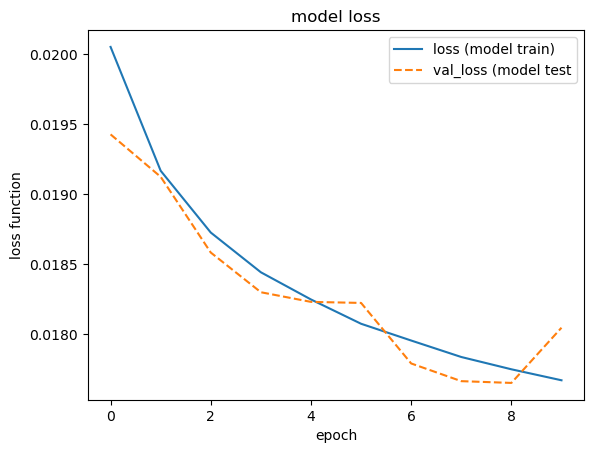

In [24]:
# plot losses to check that autoencoder is trainning correctly
plt.plot(history_cae.history['loss'])
plt.plot(history_cae.history['val_loss'],linestyle='dashed')
plt.title('model loss')
plt.ylabel('loss function')
plt.xlabel('epoch')
plt.legend(['loss (model train)', 'val_loss (model test'], loc='upper right')
plt.show()

In [25]:
cae_imags = cae.predict(X_test)

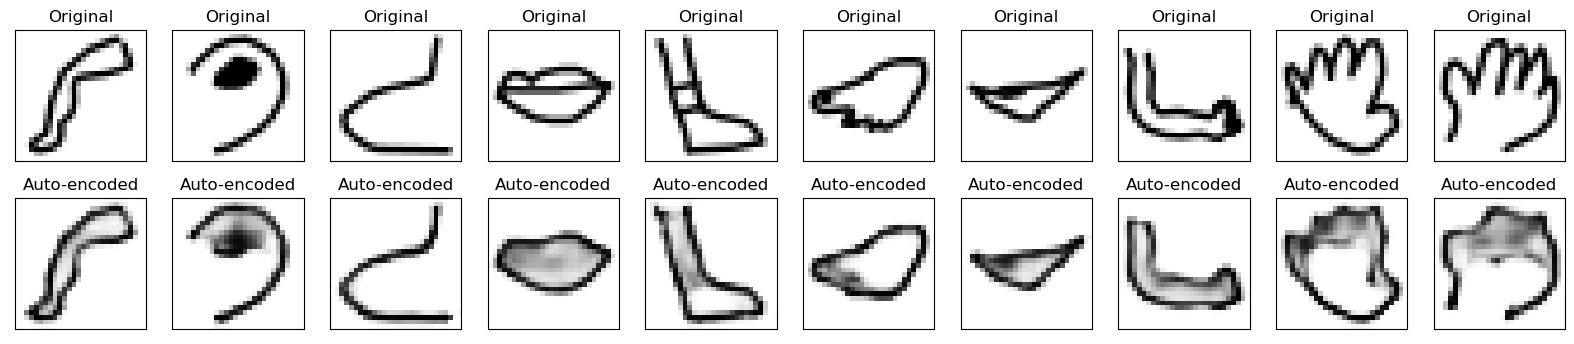

In [26]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28,1), cmap = plt.cm.binary)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title("Original")

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(cae_imags[i].reshape(28, 28, 1), cmap = plt.cm.binary)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title("Auto-encoded")
plt.show()

#### 10. Plot images in the laten space
- Predict 10 images into the laten space using the encoder only.
- Reshape the output to images and plot the laten space images. e.g. if your encoder outputs 49 features, make 7x7 image

In [27]:
# Latent space output

encoded_imags = model_enc.predict(X_test)

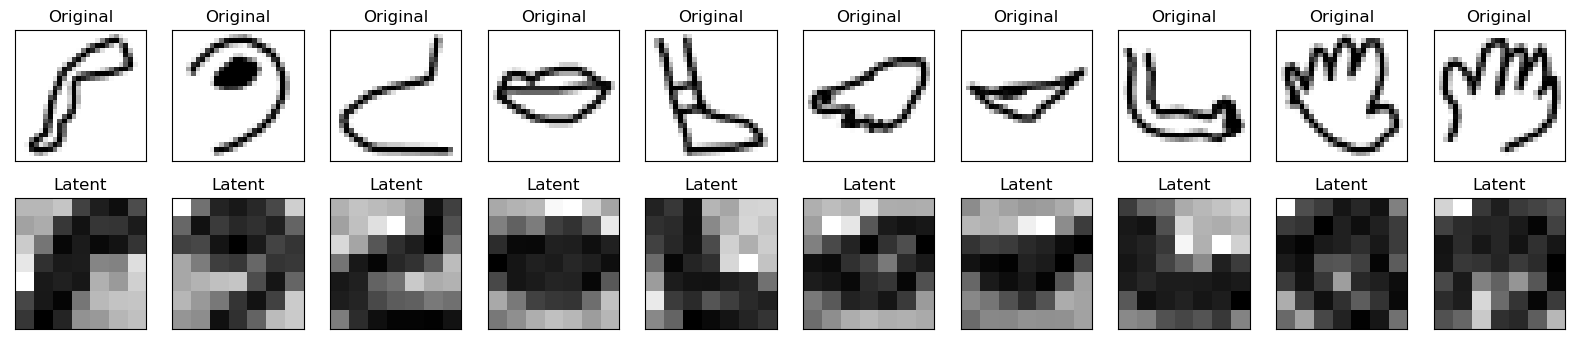

In [28]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28), cmap = plt.cm.binary)   
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title("Original")

    # Display latent space
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(encoded_imags[i].reshape(7, 7), cmap = plt.cm.binary)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title("Latent")
plt.show()

## Anomaly detection (2 marks)
---

We have introduced auto-encoders as a form of unsupervised learning, since we are not using the image labels during training. This means that auto-encoders are not ideal for image classification (at least not since we actually _have_ the labels), but they can be used for something else: anomaly detection. This is the task of identifying examples that the model considers "anomalous" with respect to the dataset used during training. 

First, we'll load in some "anomalous" data:

In [29]:
from sklearn.datasets import fetch_olivetti_faces
faces = fetch_olivetti_faces(shuffle=True)['images']
faces = faces[:,4:-4:2,4:-4:2,np.newaxis]

#### 9. Inspect the face images and the auto-encoder result (1 mark)

* How many samples does the "outlier" dataset (_i.e._ `faces`) contain?
* What is the shape of the images and what is the range of pixel intensities? Does this conform with the preprocessed quickdraw images?
* Display the first few face images.
* Get the output/prediction of the auto-encoder from the previous section when applied to all of the faces.
* Show the auto-encoded versions of the same faces you showed above. Discuss the results.

In [30]:
print("Number of samples in the outlier dataset: ", faces.shape[0])
print("Shape of the images: ", faces.shape[1], " pixels x ", faces.shape[2], " pixels.")
print("The range of pixel intensities is: (", faces.shape[3], "). ie. range [0,1], only one colour dimension.")
print("Maximum value of a pixel in this case: ", np.max(faces))
print("Minimum value of a pixel in this case: ", np.min(faces))

Number of samples in the outlier dataset:  400
Shape of the images:  28  pixels x  28  pixels.
The range of pixel intensities is: ( 1 ). ie. range [0,1], only one colour dimension.
Maximum value of a pixel in this case:  0.9710744
Minimum value of a pixel in this case:  0.020661157


**It does conform the quickdraw images format, so they can be used with the auto-encoder defined above**

_Indicative answers:_
    
* The face images have the same shape and pixel intensity range as the preprocessed quickdraw images, so they are valid inputs to the auto-encoder.
* We can see that the auto-encoder transformed faces are _very_ unlike the input images. This is because the auto-encoder was trained to learn an efficient representation of hand-written digits which is not necessarily an efficient representation for other image domains, _e.g._ faces. This examples shows that this is clearly the case. From the point of view of the auto-encoder, images of faces are _anomalies_ in that they are fundamentally unlike the images on which it was trained, and therefore we shouldn't expect it to do a good job in encoding them.

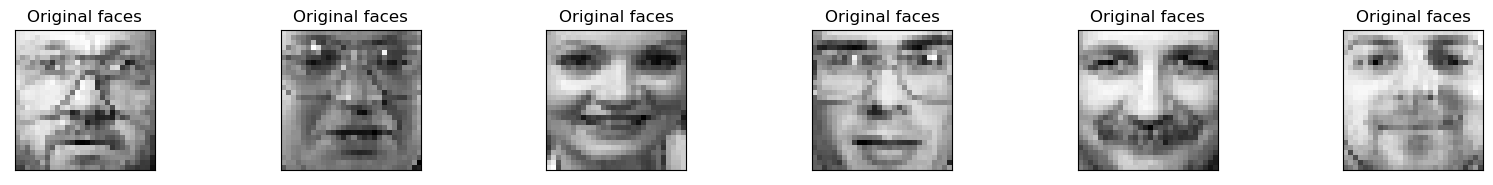

In [31]:
n = 6  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(faces[i].reshape(28, 28), cmap = plt.cm.binary)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title("Original faces")

plt.show()

In [32]:
# autoencoder prediction of faces
faces_cae = cae.predict(faces)

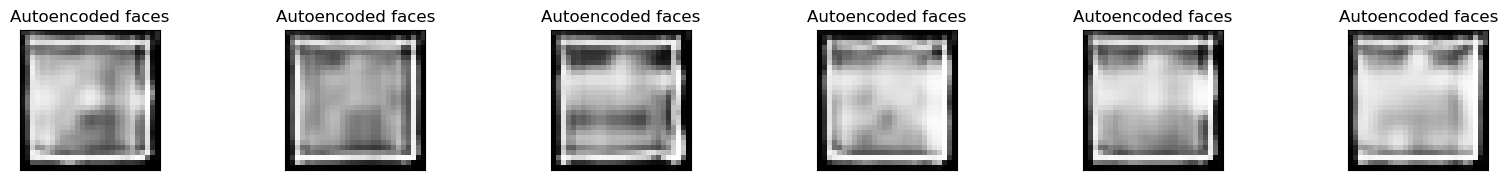

In [33]:

n = 6  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(faces_cae[i].reshape(28, 28), cmap = plt.cm.binary)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title("Autoencoded faces")

plt.show()


**The auto-encoded version of the images from the "faces" dataset looks very different to the original images due to the nature of the auto-encoder (made to learn a representation of hand-written digits so it is not ideal to represent other type of images like in this case).**

#### 11. Perform anomaly detection (1 mark)
Imagine now that we had a dataset comprised of mostly quickdraw images, but also a small subset of anomalies or "outliers"; here, in the form of black-and-white images of faceses, with the same shape as the quickdraw images.

In [34]:
# Combined MNIST images and "outliers" in a mixed dataset
mixed = np.vstack((X_test, faces))

# Shuffle the mixed dataset so the "outliers" are randomly distributed
indices = np.random.permutation(mixed.shape[0])
mixed   = mixed[indices]

The auto-encoder was trained to minimise the difference between the original and the auto-encoded image, so let's use binary cross-entropy (BCE) as our metric for the difference between an image and its auto-encoded version. The `binary_crossentropy` method provided below computes **pixel-wise BCE** for two (arrays of) images: the input and the output image.

In [35]:
def binary_crossentropy (img_in, img_out):
    assert img_in.shape == img_out.shape
    eps = np.finfo(float).eps
    img_out = np.clip(img_out, eps, 1. - eps)
    return - (img_in * np.log(img_out) + (1 - img_in) * np.log(1 - img_out))

---
* Define a new method called `difference` which takes as input two arrays of images (`img_in` and `img_out`; similar to the `binary_crossentropy`); computes the **average BCE value for each image,** or row; and returns a vector of these difference measures.
* For each image, or row, in `mixed`, compute the difference score of the auto-encoded image wrt. the original image. This is a measure of how "inlier"- or "outlier"-like an image is.
* Make a histogram of these scores, and see if you can identify any structure. It might be useful to use a logarithmic x-axis (see `plt.xscale`) along with logarithmic x-axis bins (see `np.logspace`).
* Show the 9 least and the 9 most outlying images, according to this difference score. Discuss the results.

In [36]:
cae_mixed = cae.predict(mixed)

In [37]:
# number of "images" in the mixed data set
N = mixed.shape[0]

In [38]:
# computes averafe BCE value or each image

def difference(img_in, imag_out): 
    mean_bce  = []  # list to append mean BCE values

    for i in range(N):
        mean_bce.append(np.mean(binary_crossentropy(mixed[i], cae_mixed[i])))

    return np.array(mean_bce)

In [39]:
# list of mean BCE values for each image
mean_bce = difference(mixed, cae_mixed)

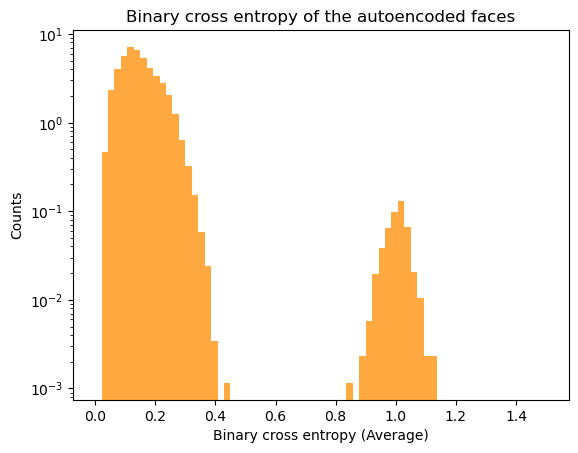

In [40]:
# plot histogram
n, bins, patches = plt.hist(mean_bce, 70, density = True, facecolor = "darkorange", alpha = 0.75, log = "true", range = [0, 1.5])
plt.title("Binary cross entropy of the autoencoded faces")
plt.ylabel("Counts")
plt.xlabel("Binary cross entropy (Average)")
plt.show();

**In the histogram we can see two "chunks" of data, the one with lower BCE correspond to the images coming from the quickdraw dataset and the second chunk (with higher BCE) correspond to the images from the face dataset. (The difference in the number of counts between each "chunk" is of about 2 order of magnitude, which makes sense as the mixed dataset is made up of 40000 normal quickdraw images and 400 faces from the faces dataset)**

In [41]:
# sort then mean_bce values to identify least and most outlying images
max = np.argsort(mean_bce)

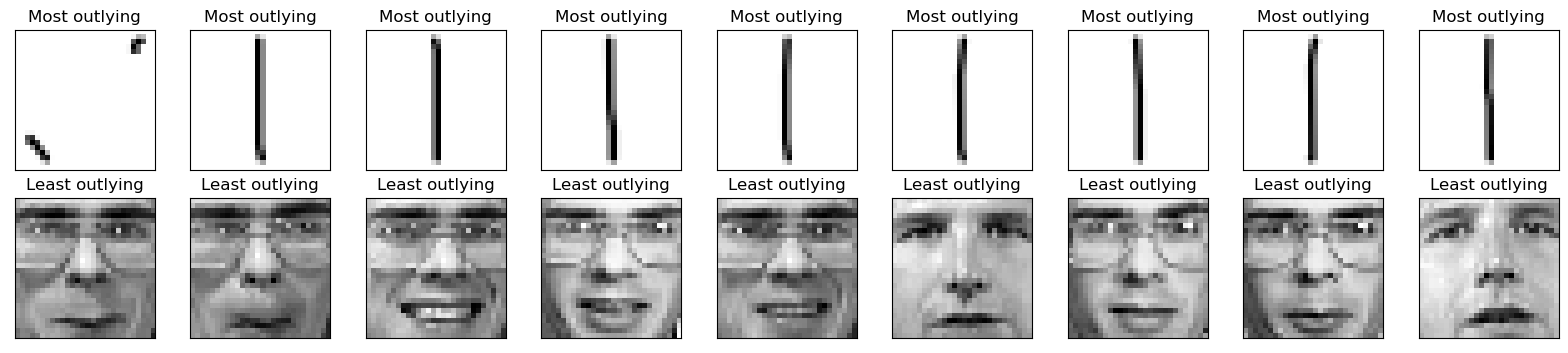

In [49]:
# print 9 least and 9 most outlying images
n = 9  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(mixed[max[i]].reshape(28, 28), cmap = plt.cm.binary)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title("Most outlying")

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(mixed[max[-(i+1)]].reshape(28, 28), cmap = plt.cm.binary)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title("Least outlying")
plt.show()

### **END OF NOTEBOOK**